In [1]:
library(DESeq2)
library(tidyverse)
library(RColorBrewer)
library(dendextend)

Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.max, which.min


Attaching package: ‘S4Vectors’

The followin

In [2]:
curdir <- "/home/jovyan/work/scratch/analysis_output"
outdir <- file.path(curdir, "out")
imgdir <- file.path(curdir, "img")

In [3]:
attach(file.path(outdir, "HTS-Pilot-Annotated-STAR-counts.RData"))
tools::md5sum(file.path(outdir, "HTS-Pilot-Annotated-STAR-counts.RData"))

/home/jovyan/work/scratch/analysis_output/out/HTS-Pilot-Annotated-STAR-counts.RData 
                                                 "88a4df858ec7c7a29e6d91548b97ae49"

### Prepare columnData (DataFrameand countData (matrix object)
### Select samples from mRNA

In [4]:
annomapres0 %>%
    dplyr::filter(enrichment_method == "mRNA")  %>%
    DataFrame ->
    columnData
rownames(columnData) <- columnData[["Label"]]

annogenecnts0 %>%
    dplyr::select(c("gene", contains('_P_'))) %>%
    as.data.frame %>%
    column_to_rownames("gene") %>%
    as.matrix ->
    countData

### Check that the row names of column Data match the
### column names of countData

In [5]:
identical(rownames(columnData), colnames( countData))

[1] TRUE

In [6]:
rownames(columnData)

[1] "1_2019_P_M1"  "10_2019_P_M1" "11_2019_P_M1" "12_2019_P_M1" "13_2019_P_M1"
 [6] "14_2019_P_M1" "15_2019_P_M1" "16_2019_P_M1" "17_2019_P_M1" "18_2019_P_M1"
[11] "19_2019_P_M1" "2_2018_P_M1"  "2_2019_P_M1"  "20_2019_P_M1" "21_2019_P_M1"
[16] "22_2019_P_M1" "23_2019_P_M1" "24_2019_P_M1" "3_2018_P_M1"  "3_2019_P_M1" 
[21] "4_2018_P_M1"  "4_2019_P_M1"  "5_2019_P_M1"  "6_2019_P_M1"  "7_2019_P_M1" 
[26] "8_2019_P_M1"  "9_2019_P_M1"

In [7]:
colnames( countData)

[1] "1_2019_P_M1"  "10_2019_P_M1" "11_2019_P_M1" "12_2019_P_M1" "13_2019_P_M1"
 [6] "14_2019_P_M1" "15_2019_P_M1" "16_2019_P_M1" "17_2019_P_M1" "18_2019_P_M1"
[11] "19_2019_P_M1" "2_2018_P_M1"  "2_2019_P_M1"  "20_2019_P_M1" "21_2019_P_M1"
[16] "22_2019_P_M1" "23_2019_P_M1" "24_2019_P_M1" "3_2018_P_M1"  "3_2019_P_M1" 
[21] "4_2018_P_M1"  "4_2019_P_M1"  "5_2019_P_M1"  "6_2019_P_M1"  "7_2019_P_M1" 
[26] "8_2019_P_M1"  "9_2019_P_M1"

### Make DESeq object on the basis of the counts

The design option allows you to specify an additive or a multiplicative model

In [10]:
#Additive model
dds_add <- DESeqDataSetFromMatrix(countData, columnData, ~ condition + genotype)

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”

In [12]:
#Multiplicative model
dds_mult <- DESeqDataSetFromMatrix(
    countData,                       # Count matrix
    columnData,                      # metadata
    ~ condition + genotype + condition:genotype) # design formula

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”

ERROR: Error in checkFullRank(modelMatrix): the model matrix is not full rank, so the model cannot be fit as specified.
  One or more variables or interaction terms in the design formula are linear
  combinations of the others and must be removed.

  Please read the vignette section 'Model matrix not full rank':

  vignette('DESeq2')


In the following demonstration, we will use the additive model. The multiplicative model will be illustrated in the appendix below.

In [13]:
dds <- dds_add

### Inspect object & Slots of an S4 class

Let's has a look at the object we have created.

In [14]:
dds

class: DESeqDataSet 
dim: 8499 27 
metadata(1): version
assays(1): counts
rownames(8499): CNAG_00001 CNAG_00002 ... large_MTrRNA small_MTrRNA
rowData names(0):
colnames(27): 1_2019_P_M1 10_2019_P_M1 ... 8_2019_P_M1 9_2019_P_M1
colData names(10): Label genotype ... prob.unique depth

In [15]:
class(dds)

[1] "DESeqDataSet"
attr(,"package")
[1] "DESeq2"

In [16]:
slotNames(dds)

[1] "design"             "dispersionFunction" "rowRanges"         
[4] "colData"            "assays"             "NAMES"             
[7] "elementMetadata"    "metadata"

In [17]:
dds@colData %>% as.data.frame %>% head(3)

,Label,genotype,condition,sample_year,libprep_person,enrichment_method,prob.gene,prob.nofeat,prob.unique,depth
,<chr>,<fct>,<fct>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1_2019_P_M1,1_2019_P_M1,WT,pH4,2019,C,mRNA,0.9701869,0.005566751,0.9757537,4805390
10_2019_P_M1,10_2019_P_M1,sre1d,pH4,2019,P,mRNA,0.9681305,0.007741957,0.9758724,3368037
11_2019_P_M1,11_2019_P_M1,sre1d,pH4,2019,P,mRNA,0.9568419,0.008394393,0.9652363,3355749


In [18]:
dds@design

~condition + genotype

The first thing you may want to do is have a look at the raw counts you have imported. The DESeq2::counts function extracts a matrix of counts (with the genes along the rows and samples along the columns). Let us first verify the dimension of this matrix.

In [19]:
dim(counts(dds))

[1] 8499   27

In [20]:
head(counts(dds),3)

,1_2019_P_M1,10_2019_P_M1,11_2019_P_M1,12_2019_P_M1,13_2019_P_M1,14_2019_P_M1,15_2019_P_M1,16_2019_P_M1,17_2019_P_M1,18_2019_P_M1,⋯,24_2019_P_M1,3_2018_P_M1,3_2019_P_M1,4_2018_P_M1,4_2019_P_M1,5_2019_P_M1,6_2019_P_M1,7_2019_P_M1,8_2019_P_M1,9_2019_P_M1
CNAG_00001,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
CNAG_00002,158,119,90,81,188,177,216,224,234,338,⋯,235,491,149,419,176,161,148,172,169,124
CNAG_00003,201,131,121,151,215,154,197,195,211,201,⋯,169,196,161,186,171,162,103,172,170,175


This slot returns gene specific information (it will be populated later)

### Estimate Size Factors

In [22]:
dds <- estimateSizeFactors(dds)

Now, compare the dds object to that of before applying the estimateSizeFactors() function. What has changed? What remains unchanged?

In [23]:
dds

class: DESeqDataSet 
dim: 8499 27 
metadata(1): version
assays(1): counts
rownames(8499): CNAG_00001 CNAG_00002 ... large_MTrRNA small_MTrRNA
rowData names(0):
colnames(27): 1_2019_P_M1 10_2019_P_M1 ... 8_2019_P_M1 9_2019_P_M1
colData names(11): Label genotype ... depth sizeFactor

In [24]:
sizeFactors(dds)

1_2019_P_M1 10_2019_P_M1 11_2019_P_M1 12_2019_P_M1 13_2019_P_M1 14_2019_P_M1 
   1.5788545    1.0612415    1.0287859    0.9589858    0.7613800    0.7494626 
15_2019_P_M1 16_2019_P_M1 17_2019_P_M1 18_2019_P_M1 19_2019_P_M1  2_2018_P_M1 
   0.7139516    0.8936922    0.8847406    0.9270229    0.7391543    1.0175826 
 2_2019_P_M1 20_2019_P_M1 21_2019_P_M1 22_2019_P_M1 23_2019_P_M1 24_2019_P_M1 
   1.6567641    0.7682112    0.5813234    0.6244931    0.7441516    0.7973761 
 3_2018_P_M1  3_2019_P_M1  4_2018_P_M1  4_2019_P_M1  5_2019_P_M1  6_2019_P_M1 
   1.1265855    1.5145511    1.0097869    1.4135174    1.4326617    1.2337070 
 7_2019_P_M1  8_2019_P_M1  9_2019_P_M1 
   1.3899637    1.4314778    1.1631059

It is preferable to limit the number of decimal places. Next show the size factors rounded to 3 decimal places

In [25]:
round(sizeFactors(dds),3)

1_2019_P_M1 10_2019_P_M1 11_2019_P_M1 12_2019_P_M1 13_2019_P_M1 14_2019_P_M1 
       1.579        1.061        1.029        0.959        0.761        0.749 
15_2019_P_M1 16_2019_P_M1 17_2019_P_M1 18_2019_P_M1 19_2019_P_M1  2_2018_P_M1 
       0.714        0.894        0.885        0.927        0.739        1.018 
 2_2019_P_M1 20_2019_P_M1 21_2019_P_M1 22_2019_P_M1 23_2019_P_M1 24_2019_P_M1 
       1.657        0.768        0.581        0.624        0.744        0.797 
 3_2018_P_M1  3_2019_P_M1  4_2018_P_M1  4_2019_P_M1  5_2019_P_M1  6_2019_P_M1 
       1.127        1.515        1.010        1.414        1.433        1.234 
 7_2019_P_M1  8_2019_P_M1  9_2019_P_M1 
       1.390        1.431        1.163

Now that the size factors have been estimated, we can get "normalized" counts. Here we print three data frames together to easily compare them.

In [26]:
# original count
head(counts(dds),3)

# normalized count
head(counts(dds, normalize = TRUE), 3)

# normalized manually using size factors
counts(dds)[1:3,] %>% 
    apply(., 1, function(row){row / sizeFactors(dds)}) %>%
    t

,1_2019_P_M1,10_2019_P_M1,11_2019_P_M1,12_2019_P_M1,13_2019_P_M1,14_2019_P_M1,15_2019_P_M1,16_2019_P_M1,17_2019_P_M1,18_2019_P_M1,⋯,24_2019_P_M1,3_2018_P_M1,3_2019_P_M1,4_2018_P_M1,4_2019_P_M1,5_2019_P_M1,6_2019_P_M1,7_2019_P_M1,8_2019_P_M1,9_2019_P_M1
CNAG_00001,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
CNAG_00002,158,119,90,81,188,177,216,224,234,338,⋯,235,491,149,419,176,161,148,172,169,124
CNAG_00003,201,131,121,151,215,154,197,195,211,201,⋯,169,196,161,186,171,162,103,172,170,175


,1_2019_P_M1,10_2019_P_M1,11_2019_P_M1,12_2019_P_M1,13_2019_P_M1,14_2019_P_M1,15_2019_P_M1,16_2019_P_M1,17_2019_P_M1,18_2019_P_M1,⋯,24_2019_P_M1,3_2018_P_M1,3_2019_P_M1,4_2018_P_M1,4_2019_P_M1,5_2019_P_M1,6_2019_P_M1,7_2019_P_M1,8_2019_P_M1,9_2019_P_M1
CNAG_00001,0.0000,0.0000,0.00000,0.00000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,⋯,0.0000,0.0000,0.00000,0.0000,0.0000,0.0000,0.00000,0.0000,0.0000,0.0000
CNAG_00002,100.0726,112.1328,87.48176,84.46423,246.9201,236.1692,302.5415,250.6456,264.4843,364.6080,⋯,294.7166,435.8302,98.37898,414.9391,124.5121,112.3782,119.96366,123.7442,118.0598,106.6111
CNAG_00003,127.3075,123.4403,117.61436,157.45801,282.3820,205.4806,275.9291,218.1959,238.4880,216.8231,⋯,211.9452,173.9770,106.30212,184.1973,120.9748,113.0762,83.48822,123.7442,118.7584,150.4592


,1_2019_P_M1,10_2019_P_M1,11_2019_P_M1,12_2019_P_M1,13_2019_P_M1,14_2019_P_M1,15_2019_P_M1,16_2019_P_M1,17_2019_P_M1,18_2019_P_M1,⋯,24_2019_P_M1,3_2018_P_M1,3_2019_P_M1,4_2018_P_M1,4_2019_P_M1,5_2019_P_M1,6_2019_P_M1,7_2019_P_M1,8_2019_P_M1,9_2019_P_M1
CNAG_00001,0.0000,0.0000,0.00000,0.00000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,⋯,0.0000,0.0000,0.00000,0.0000,0.0000,0.0000,0.00000,0.0000,0.0000,0.0000
CNAG_00002,100.0726,112.1328,87.48176,84.46423,246.9201,236.1692,302.5415,250.6456,264.4843,364.6080,⋯,294.7166,435.8302,98.37898,414.9391,124.5121,112.3782,119.96366,123.7442,118.0598,106.6111
CNAG_00003,127.3075,123.4403,117.61436,157.45801,282.3820,205.4806,275.9291,218.1959,238.4880,216.8231,⋯,211.9452,173.9770,106.30212,184.1973,120.9748,113.0762,83.48822,123.7442,118.7584,150.4592


**Exercise:** How do you get the raw counts for gene  "GeneID: CNAG_05845"?

In [27]:
counts(dds, normalize = TRUE)["CNAG_05845",]

1_2019_P_M1 10_2019_P_M1 11_2019_P_M1 12_2019_P_M1 13_2019_P_M1 14_2019_P_M1 
    1767.737     1553.841     1646.601     1715.354     1649.636     1606.484 
15_2019_P_M1 16_2019_P_M1 17_2019_P_M1 18_2019_P_M1 19_2019_P_M1  2_2018_P_M1 
    1582.740     1558.702     1749.665     1530.707     1848.058     1725.658 
 2_2019_P_M1 20_2019_P_M1 21_2019_P_M1 22_2019_P_M1 23_2019_P_M1 24_2019_P_M1 
    1485.426     1817.209     1880.193     1719.795     1859.836     1817.210 
 3_2018_P_M1  3_2019_P_M1  4_2018_P_M1  4_2019_P_M1  5_2019_P_M1  6_2019_P_M1 
    1746.871     1394.473     1671.640     1533.055     1546.073     1667.333 
 7_2019_P_M1  8_2019_P_M1  9_2019_P_M1 
    1495.722     1406.938     1627.539

**Exercise:** Get a summary (mean, median, quantiles etc ) of the size factors

In [32]:
summary(sizeFactors(dds))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.5813  0.7648  1.0098  1.0445  1.3118  1.6568 

Before going to the next step, let's check whether the dispersionFunction slot is empty

In [33]:
dds@dispersionFunction

function (q) 
coefs[1] + coefs[2]/q
<bytecode: 0x55a68ed7d840>
<environment: 0x55a68ed7a068>
attr(,"coefficients")
asymptDisp  extraPois 
0.01313002 0.88150567 
attr(,"fitType")
[1] "parametric"
attr(,"varLogDispEsts")
[1] 0.8882098
attr(,"dispPriorVar")
[1] 0.7973632

### Estimate Dispersion parameters (for each gene)

In [34]:
dds <- estimateDispersions(dds)

found already estimated dispersions, replacing these
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates


In [35]:
dds

class: DESeqDataSet 
dim: 8499 27 
metadata(1): version
assays(2): counts mu
rownames(8499): CNAG_00001 CNAG_00002 ... large_MTrRNA small_MTrRNA
rowData names(10): baseMean baseVar ... dispOutlier dispMAP
colnames(27): 1_2019_P_M1 10_2019_P_M1 ... 8_2019_P_M1 9_2019_P_M1
colData names(11): Label genotype ... depth sizeFactor

In [36]:
dds@dispersionFunction

function (q) 
coefs[1] + coefs[2]/q
<bytecode: 0x55a68ed7d840>
<environment: 0x55a68ee90578>
attr(,"coefficients")
asymptDisp  extraPois 
0.01313002 0.88150567 
attr(,"fitType")
[1] "parametric"
attr(,"varLogDispEsts")
[1] 0.8882098
attr(,"dispPriorVar")
[1] 0.7973632

Verify that the number of dispersion factors equals the number of genes

In [37]:
length(dispersions(dds))
nrow(dds)

[1] 8499

[1] 8499

We can extract the gene specific dispersion factors using dispersions(). Note that there will be one number per gene. We look at the first four genes (rounded to 4 decimal places)

In [42]:
mcols(dds)[1:4,] %>% as.data.frame

,baseMean,baseVar,allZero,dispGeneEst,dispGeneIter,dispFit,dispersion,dispIter,dispOutlier,dispMAP
,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<dbl>
CNAG_00001,0.0000,0.000,TRUE,NA,NA,NA,NA,NA,NA,NA
CNAG_00002,218.3189,12249.303,FALSE,0.010389828,9,0.01716772,0.011484015,9,FALSE,0.011484015
CNAG_00003,167.8595,2813.464,FALSE,0.021587945,8,0.01838147,0.021053400,5,FALSE,0.021053400
CNAG_00004,568.6253,2176.379,FALSE,0.003050718,7,0.01468026,0.004228907,9,FALSE,0.004228907


**Exercise:** Provide statistical summaries of the dispersion factors

In [43]:
summary(dispersions(dds))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
 0.0010  0.0068  0.0127  0.2016  0.0272 27.0000     346 

**Exercise:** Summarize the dispersion factors using a box plot (may want to log transform)

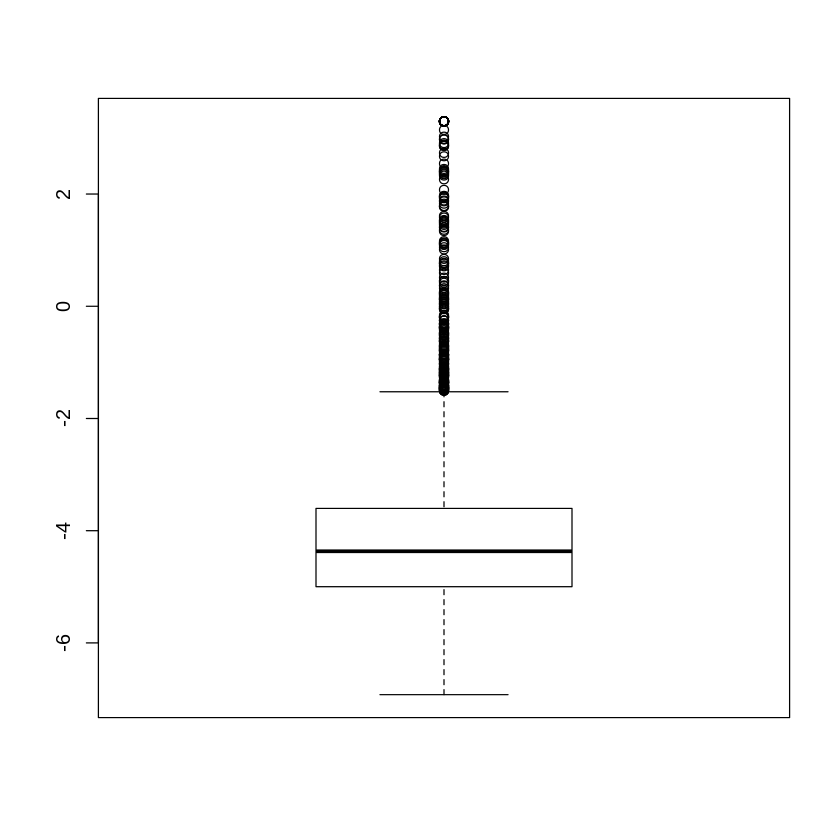

In [39]:
boxplot(log(dispersions(dds)))

# Differential Expression Analysis

We can now conduct a differential expression analysis using the DESeq() function. Keep in mind that to get to this step, we first estimated the size factors and then the dispersion parameters.

In [40]:
ddsDE <- DESeq(dds)

using pre-existing size factors
estimating dispersions
found already estimated dispersions, replacing these
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


Note that currently, the model we have is an additive model, which does not include the interaction term of Media and Strain

In [50]:
mtdf$genotype

[1] "WT"    "WT"    "WT"    "WT"    "WT"    "WT"    "sre1d" "sre1d" "sre1d"
[10] "sre1d" "sre1d" "sre1d" "WT"    "WT"    "WT"    "WT"    "WT"    "WT"   
[19] "sre1d" "sre1d" "sre1d" "sre1d" "sre1d" "sre1d" "WT"    "WT"    "WT"   
[28] "WT"    "WT"    "WT"    "WT"    "WT"    "WT"    "WT"    "WT"    "WT"

Therefore, We can get the results for the differential expression analysis using results(). Here, we can compare two group of samples specified by the contrast. (If not, the default contrast would be the last term in your additive model `design(dds)`).

In [66]:
# compare two Media
myres_media1 <- results(ddsDE, contrast = c("condition", "pH4", "pH8"))
myres_media1[1:4,]

log2 fold change (MLE): condition pH4 vs pH8 
Wald test p-value: condition pH4 vs pH8 
DataFrame with 4 rows and 6 columns
                   baseMean     log2FoldChange              lfcSE
                  <numeric>          <numeric>          <numeric>
CNAG_00001                0                 NA                 NA
CNAG_00002 218.318856961924  -1.34671316999061 0.0776260608527034
CNAG_00003 167.859533498372 -0.836195747746304 0.0974969350690887
CNAG_00004 568.625297017212 -0.090946962884466 0.0457569650946838
                        stat               pvalue                 padj
                   <numeric>            <numeric>            <numeric>
CNAG_00001                NA                   NA                   NA
CNAG_00002 -17.3487248379899 2.01671263009856e-67 1.88774489933336e-66
CNAG_00003 -8.57663625173197 9.76879357014875e-18 2.64337782865658e-17
CNAG_00004 -1.98760915843679   0.0468549326287457   0.0579678703675513

In [67]:
# compare two Media
myres_media2 <- results(ddsDE, contrast = c("condition", "pH4", "YPD"))
myres_media2[1:4,]

log2 fold change (MLE): condition pH4 vs YPD 
Wald test p-value: condition pH4 vs YPD 
DataFrame with 4 rows and 6 columns
                   baseMean     log2FoldChange              lfcSE
                  <numeric>          <numeric>          <numeric>
CNAG_00001                0                 NA                 NA
CNAG_00002 218.318856961924  -1.89205987556738   0.11891066874708
CNAG_00003 167.859533498372 -0.569473262837094  0.159074837922292
CNAG_00004 568.625297017212  0.137987858412003 0.0754376085293527
                        stat               pvalue                 padj
                   <numeric>            <numeric>            <numeric>
CNAG_00001                NA                   NA                   NA
CNAG_00002 -15.9116073898444 5.26443437173016e-57 9.13211349632256e-56
CNAG_00003 -3.57990786145123 0.000343715380854169 0.000541823569238987
CNAG_00004  1.82916533413585    0.067374843886894    0.084391934584398

In [52]:
# compare two Strains
myres_strain <- results(ddsDE, contrast = c("genotype", "WT", "sre1d"))
myres_strain

log2 fold change (MLE): genotype WT vs sre1d 
Wald test p-value: genotype WT vs sre1d 
DataFrame with 8499 rows and 6 columns
                        baseMean     log2FoldChange              lfcSE
                       <numeric>          <numeric>          <numeric>
CNAG_00001                     0                 NA                 NA
CNAG_00002      218.318856961924 0.0363395679237975  0.077510414166667
CNAG_00003      167.859533498372 0.0343283377160536 0.0975266223406203
CNAG_00004      568.625297017212 0.0254034940497724 0.0456673073843595
CNAG_00005       46.338980040365 -0.383427481212836  0.179311509448112
...                          ...                ...                ...
ENSRNA049551942                0                 NA                 NA
ENSRNA049551964                0                 NA                 NA
ENSRNA049551993                0                 NA                 NA
large_MTrRNA    5224.85717223016 -0.406254674594512  0.130621890670529
small_MTrRNA    1799.6

In [53]:
data.frame(desc = mcols(myres_strain)$description) 

desc
<fct>
mean of normalized counts for all samples
log2 fold change (MLE): genotype WT vs sre1d
standard error: genotype WT vs sre1d
Wald statistic: genotype WT vs sre1d
Wald test p-value: genotype WT vs sre1d
BH adjusted p-values


### Fit NB MLE model

In [54]:
dds <- DESeq(dds)

using pre-existing size factors
estimating dispersions
found already estimated dispersions, replacing these
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


### Rlog "normalized" expressions

In [55]:
rld <- rlog(dds)

### Show top 10 hits

In [56]:
results(dds, tidy=TRUE) %>% arrange(pvalue) %>% head(10)

row,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
CNAG_04804,975.2208,9.4415159,0.27134662,34.79504,2.891036e-265,2.357062e-261
CNAG_02493,1905.3337,-1.2486457,0.06554634,-19.04981,6.593591e-81,2.687877e-77
CNAG_03857,9600.5419,-0.7540110,0.04068128,-18.53459,1.086077e-76,2.951595e-73
CNAG_05889,4219.5604,-0.5766220,0.03340899,-17.25948,9.495514e-67,1.935423e-63
CNAG_05424,18925.6477,-0.7239733,0.04270269,-16.95381,1.803775e-64,2.941236e-61
CNAG_07027,1559.4150,-0.3973747,0.02480616,-16.01919,9.386352e-58,1.275449e-54
CNAG_03680,793.3428,-0.8221552,0.05194107,-15.82862,1.975211e-56,2.300556e-53
CNAG_05258,17228.2276,-0.7610845,0.05090991,-14.94964,1.566046e-50,1.595996e-47
CNAG_01119,5964.4651,1.4836425,0.09986975,14.85577,6.382651e-50,5.781973e-47


### A function for exploring interactions

Warning message:
“Removed 27 rows containing missing values (geom_point).”

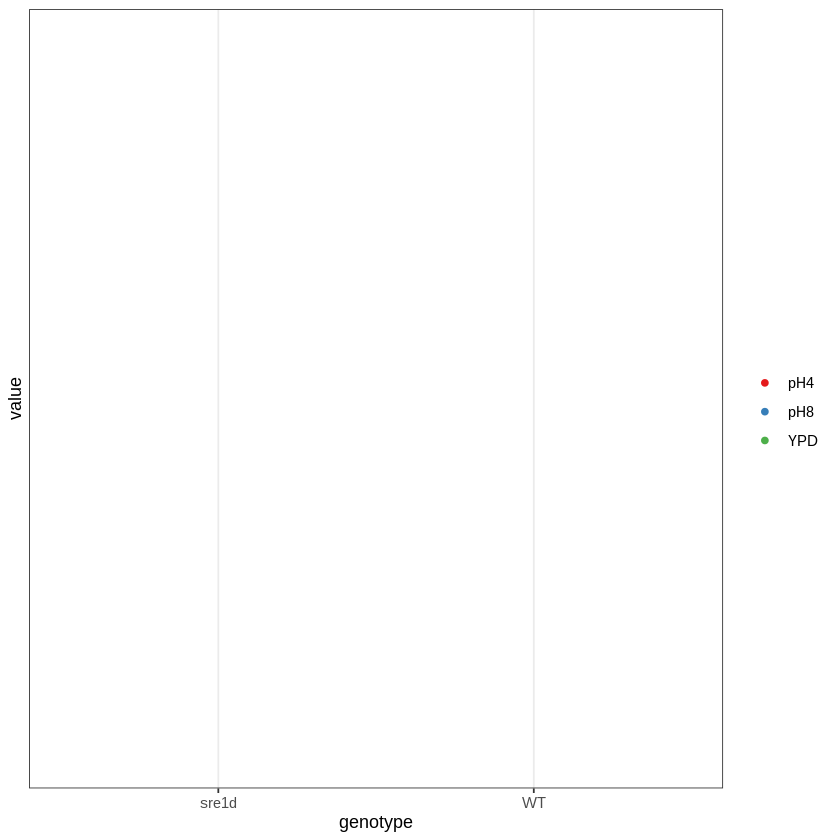

In [61]:
myinteractplot <- function(mydds, geneid) {
    assay(mydds) %>%
        as_tibble(rownames="gene") %>%
        filter(gene==geneid) %>%
        gather(Label, value, -gene) %>%
        select(-gene) -> genedat

    colData(mydds) %>%
        as.data.frame %>%
        as_tibble %>%
        full_join(genedat, by="Label") -> genedat

    mygeom <-  geom_point()
    mypal <- scale_colour_manual(name="",  values =brewer.pal(3,"Set1"))
    mytheme <- theme_bw()

    ggplot(genedat, aes(x=genotype, y=value, color=condition))+
        mygeom+mytheme+mypal
}

myinteractplot(rld, "gene5845")

In [62]:
assay(rld) %>%
    t() %>%
    dist %>%
    hclust(method = "complete") %>%
    as.dendrogram ->
    mydend

In [63]:
dendplot <- function(mydend, columndata, labvar, colvar, pchvar) {
    cols <- factor(columndata[[colvar]][order.dendrogram(mydend)])
    collab <- brewer.pal(max(3,nlevels(cols)),"Set1")[cols]
    pchs <- factor(columndata[[pchvar]][order.dendrogram(mydend)])
    pchlab <- seq_len(nlevels(pchs))[pchs]
    lablab <- columndata[[labvar]][order.dendrogram(mydend)]
    
    mydend %>% 
        set("labels_cex",1) %>% 
        set("labels_col",collab) %>%
        set("leaves_pch",pchlab) %>%
        set("labels", lablab)
}

In [65]:
pdf(file.path(outdir, "josh.pdf"))
dendplot(mydend, columnData, "genotype", "genotype", "condition") %>% plot
dendplot(mydend, columnData, "condition", "genotype", "condition") %>% plot
dendplot(mydend, columnData, "Label", "genotype", "condition") %>% plot
graphics.off()